In [2]:
from functools import reduce

import torch


class RotationAndFlipLayer(torch.nn.Module):
    """Custom layer that transform an input into a stack of rotations and flips.

    It assumes an input of, at least, (B, L, C, W, H) where:
    - B: Batch
    - L: Levels
    - C: Channels
    - W: Width
    - H: Height

    For each element in the input, the transformation works as follows:
    - If `rot` is enabled, then the element is rotated in 90, 180 and 270 degrees.
    - If `flip` is enabled, then the element is flipped horizontally.

    Notice that rotations are applied also in flipped vectors. Then, if `rot` and `flip`
    are enabled, then from one element, eight vectors will be generated, where:
    - 1 vector is the original element
    - 3 vectors are rotations (90, 180, 270) of the original element
    - 1 vector is the horizontal flipped version of the original element.
    - 3 vectors are rotations (90, 180, 270) of the horizontal flipped vector.

    It will returns a new tensor of (B * L * T, C, W, H)
    Where T = (`flip==True` + 1) * (3 * `rot==True` + 1) 
    """
    def __init__(self, rot: bool = True, flip: bool = True):
        super().__init__()  # type: ignore
        self.rot = rot
        self.flip = flip
        self.n_transforms = (int(flip) + 1) * (3 * int(rot) + 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        stacked = reduce(lambda x, y: x * y, x.shape[:-3], 1)

        if self.rot is False and self.flip is False:
            x = x.reshape(stacked, x.shape[-3], x.shape[-2], x.shape[-1])
            return x

        w_dim = len(x.shape) - 2
        h_dim = len(x.shape) - 1
        transforms: tuple[torch.Tensor, ...]

        if self.rot is False:
            flipped = x.flip(dims=(h_dim,))
            transforms = (x, flipped)

        elif self.flip is False:
            rot90 = x.rot90(k=1, dims=(w_dim, h_dim))
            rot180 = x.rot90(k=2, dims=(w_dim, h_dim))
            rot270 = x.rot90(k=3, dims=(w_dim, h_dim))
            transforms = (x, rot90, rot180, rot270)

        else:
            rot90 = x.rot90(k=1, dims=(w_dim, h_dim))
            rot180 = x.rot90(k=2, dims=(w_dim, h_dim))
            rot270 = x.rot90(k=3, dims=(w_dim, h_dim))
            flipped = x.flip(dims=(h_dim,))
            flipped_rot90 = flipped.rot90(k=1, dims=(w_dim, h_dim))
            flipped_rot180 = flipped.rot90(k=2, dims=(w_dim, h_dim))
            flipped_rot270 = flipped.rot90(k=3, dims=(w_dim, h_dim))
            transforms = (
                x,
                rot90,
                rot180,
                rot270,
                flipped,
                flipped_rot90,
                flipped_rot180,
                flipped_rot270,
            )

        x = torch.cat(transforms, dim=1)

        return x.reshape(
            stacked * self.n_transforms, x.shape[-3], x.shape[-2], x.shape[-1]
        )

In [3]:
from dataclasses import dataclass


@dataclass
class DelightCnnParameters:
    """Defines DelightCnn parameters.

    Attributes:
    - nconv1: Number of out channels for first convolutional layer.
    - nconv2: Number of out channels for second convolutional layer.
    - nconv3: Number of out channels for third convolutional layer.
    - ndense: Number of out features for first fully-connected layer.
    - dropout: Probability of dropout. 0 means no dropout.
    - channels: Number of channels expected from the dataset.
    - levels: Quantity of levels expected from the dataset.
    - rot: Applies a rotation transformation on the input.
    - flip: Applies a flip transformation on the input.
    """

    nconv1: int
    nconv2: int
    nconv3: int
    ndense: int
    dropout: float
    channels: int
    levels: int
    rot: bool
    flip: bool

In [37]:
import math
from collections import OrderedDict

import torch

class DelightCnn(torch.nn.Module):
    def __init__(self, options: DelightCnnParameters):
        super().__init__()  # type: ignore
        bottleneck: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                ("conv1", torch.nn.Conv2d(options.channels, options.nconv1, 3)),
                ("relu1", torch.nn.ReLU()),
                ("mp1", torch.nn.MaxPool2d(2)),
                ("conv2", torch.nn.Conv2d(options.nconv1, options.nconv2, 3)),
                ("relu2", torch.nn.ReLU()),
                ("mp2", torch.nn.MaxPool2d(2)),
                ("conv3", torch.nn.Conv2d(options.nconv2, options.nconv3, 3)),
                ("relu3", torch.nn.ReLU()),
                ("flatten", torch.nn.Flatten()),
            ]
        )
        regression: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                (
                    "input_layer_ffcc",
                    torch.nn.Linear(
                        in_features=4*4*options.nconv3*options.levels,
                        out_features=options.ndense,
                    ),
                ),
                ("tanh", torch.nn.Tanh()),
                ("dropout", torch.nn.Dropout(p=options.dropout)),
                ("out", torch.nn.Linear(in_features=options.ndense, out_features=2)),
            ]
        )

        self.rot_and_flip = RotationAndFlipLayer(rot=options.rot, flip=options.flip)
        self.bottleneck = torch.nn.Sequential(bottleneck)
        self.regression = torch.nn.Sequential(regression)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch = x.shape[0]  

        print(x.shape)

        x = self.rot_and_flip(x)

        print(x.shape)
        x = self.bottleneck(x)
        return x
        # print(x.shape)
        # x = x.reshape(batch, self.rot_and_flip.n_transforms, -1)
        # print(x.shape)

        # x = self.regression(x)
        # print(x.shape)

        # return x

In [5]:
import os
import sys
import logging
from functools import partial
from typing import Any, Protocol, cast
import gdown
import torch
import numpy as np

import matplotlib.pyplot as plt

In [6]:
X_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_train.npy")
X_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_validation.npy")
X_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_test.npy")

y_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_train.npy")
y_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_validation.npy")
y_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_test.npy")

In [ ]:
model_parameters = DelightCnnParameters(
    nconv1=52,
    nconv2=57,
    nconv3=41,
    ndense=128,
    dropout=0.06,
    channels=1,
    levels=5,
    rot=True,
    flip=True,
)

model = DelightCnn(model_parameters)


In [40]:
prueba = torch.tensor(X_train[:2]).permute(0,3,1,2).unsqueeze(2)
prueba.shape

torch.Size([2, 5, 1, 30, 30])

In [38]:
model = DelightCnn(model_parameters)
rot =RotationAndFlipLayer()

In [17]:
transform = rot(prueba[1,0,:].unsqueeze(0).unsqueeze(1))
transform.shape

torch.Size([8, 1, 30, 30])

In [18]:
def get_transformed_points(y: np.ndarray) -> tuple[np.ndarray, ...]:
    y90 = (-1, 1) * y[:, ::-1]
    y180 = (-1, 1) * y90[:, ::-1]
    y270 = (-1, 1) * y180[:, ::-1]
    yflip = (1, -1) * y
    yflip90 = (-1, 1) * yflip[:, ::-1]
    yflip180 = (-1, 1) * yflip90[:, ::-1]
    yflip270 = (-1, 1) * yflip180[:, ::-1]

    return np.concatenate([y, y90, y180, y270, yflip, yflip90, yflip180, yflip270])

In [12]:
y_trans = get_transformed_points(y_train[1:2])

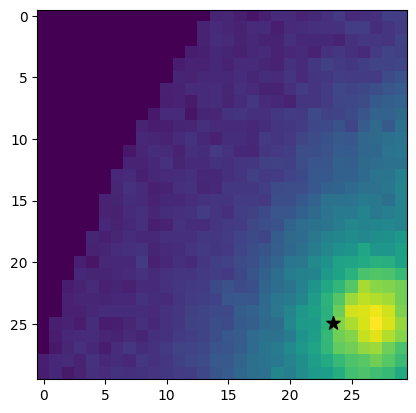

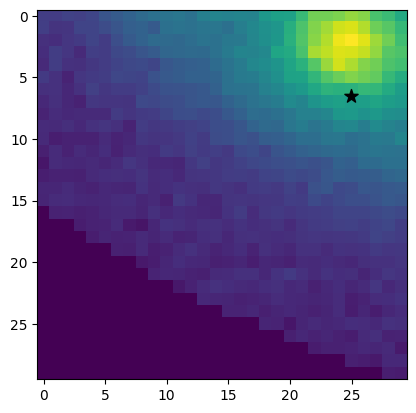

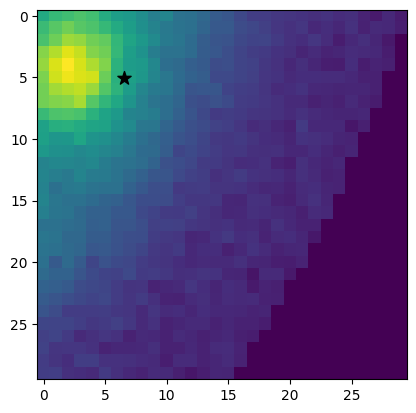

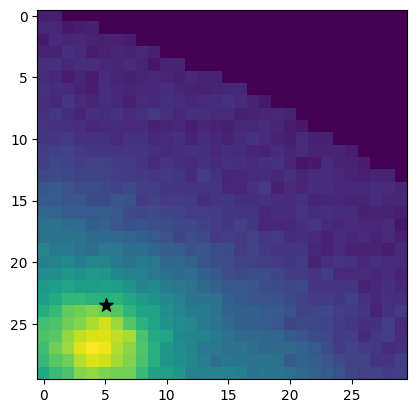

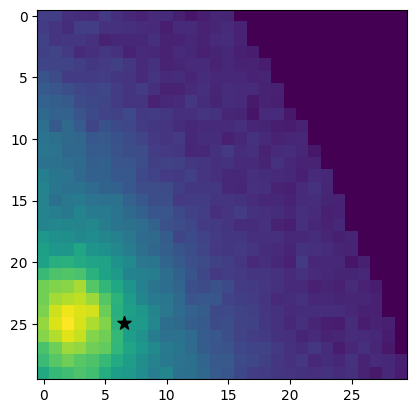

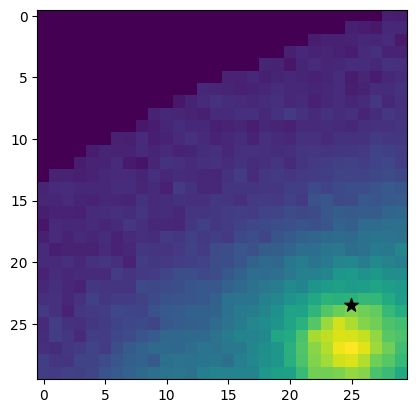

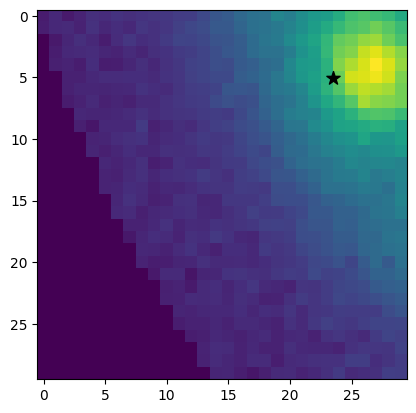

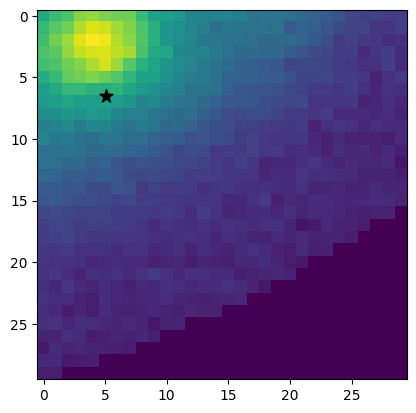

In [421]:
for i in range(8):
    plt.imshow(transform[i][0])
    plt.scatter(15+y_trans[i][1], 15+y_trans[i][0], color='black', marker='*', s=100)
    plt.show()

In [97]:
bottleneck: OrderedDict[str, torch.nn.Module] = OrderedDict(
    [
        ("conv1", torch.nn.Conv2d(1, 10, 3)),
        ("relu1", torch.nn.ReLU()),
        ("mp1", torch.nn.MaxPool2d(2)),
        ("conv2", torch.nn.Conv2d(10, 20, 3)),
        ("relu2", torch.nn.ReLU()),
        ("mp2", torch.nn.MaxPool2d(2)),
        ("conv3", torch.nn.Conv2d(20, 41, 3)),
        ("relu3", torch.nn.ReLU()),
        ("flatten", torch.nn.Flatten()),
    ]
)


rot_and_flip = RotationAndFlipLayer(rot=True, flip=True)
rot_and_flip_false = RotationAndFlipLayer(rot=False, flip=False)

bottleneck_layer = torch.nn.Sequential(bottleneck)

In [212]:
import torch.nn as nn

bottleneck_layer = nn.Sequential(
    nn.Conv2d(1, 10, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(10, 20, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(20, 41, 3),
    nn.ReLU(),
    nn.Flatten(),
)

In [148]:
prueba = torch.tensor(X_train[:2]).permute(0,3,1,2).unsqueeze(2)
prueba.shape


torch.Size([2, 5, 1, 30, 30])

In [169]:
stacked = reduce(lambda x, y: x * y, prueba.shape[:-3], 1)

x = prueba.reshape(stacked, prueba.shape[-3], prueba.shape[-2], prueba.shape[-1])

In [249]:
output = bottleneck_layer(rot_and_flip(prueba.float()))
output2= bottleneck_layer(rot_and_flip_false(prueba.float()))


In [272]:
output.shape

torch.Size([80, 656])

In [250]:
reshape = output.reshape(2, 8, -1)
reshape.shape

torch.Size([2, 8, 3280])

In [283]:
idx = 0

for i in range(2):
    for t in range(8):
        cat = torch.cat([output[j] for j in range(idx, idx + 5)])
        idx += 5
        print((cat == reshape[i][t]).all())
        print(torch.allclose(cat, reshape[i][t], atol=1e-50))


tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True
tensor(True)
True


In [ ]:
reshape[1][0].shape

torch.Size([3280])

In [268]:
cat = torch.cat([output2[5],output2[6],output2[7],output2[8],output2[9]])

In [271]:
torch.allclose(cat, reshape[1][0], atol=1e-6)


True

In [263]:
(torch.cat([output2[0],output2[1],output2[2],output2[3],output2[4]]) ==reshape[0][0]).all()

tensor(False)

In [225]:
(rot_and_flip(prueba.float())[0] == rot_and_flip_false(prueba.float())[0]).all()

tensor(True)

In [214]:
reshape = output.reshape(2, 8, -1)
reshape.shape

torch.Size([2, 8, 3280])

In [236]:
torch.allclose(output[0], output2[0], atol=1e-7)


True

In [247]:
(output[0] == output2[0]).all()

tensor(True)

In [184]:
out1.shape

torch.Size([10, 656])

In [203]:
rot_true.shape

torch.Size([80, 1, 30, 30])

In [196]:
rot_true = rot_and_flip(prueba.float())
rot_false = rot_and_flip_false(prueba.float())

In [206]:
(bottleneck_layer(rot_true[40]) == bottleneck_layer(rot_false[5])).all()

tensor(True)

In [194]:
rot_and_flip_false(prueba.float()).shape

torch.Size([10, 1, 30, 30])

In [191]:
out1[1].float() == output[1].float()

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True, False, False, False,
         True, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
rot_and_flip_false(prueba.float())[0] ==

tensor([[[0.3038, 0.3489, 0.2964, 0.2512, 0.2532, 0.2585, 0.2421, 0.1670,
          0.1841, 0.1782, 0.1739, 0.1951, 0.1632, 0.2223, 0.2108, 0.1998,
          0.1788, 0.1787, 0.2215, 0.1769, 0.1778, 0.2036, 0.1775, 0.1689,
          0.1890, 0.1897, 0.1871, 0.2218, 0.1766, 0.2315],
         [0.3125, 0.3787, 0.3626, 0.3130, 0.2556, 0.2219, 0.2037, 0.1915,
          0.1659, 0.1645, 0.1882, 0.1929, 0.1796, 0.1921, 0.1960, 0.2311,
          0.1449, 0.1653, 0.2045, 0.2084, 0.1737, 0.1880, 0.1848, 0.2135,
          0.2315, 0.2246, 0.2197, 0.2266, 0.1879, 0.2493],
         [0.3177, 0.3181, 0.2629, 0.2895, 0.2633, 0.1993, 0.1929, 0.1633,
          0.1793, 0.2333, 0.1863, 0.1994, 0.1956, 0.1800, 0.2170, 0.2471,
          0.2083, 0.2131, 0.2143, 0.2570, 0.2275, 0.2250, 0.2291, 0.1779,
          0.1987, 0.1920, 0.2071, 0.2591, 0.2866, 0.2062],
         [0.2645, 0.2791, 0.2753, 0.2351, 0.2474, 0.2748, 0.2345, 0.2059,
          0.2141, 0.2366, 0.2545, 0.2301, 0.2197, 0.2307, 0.1952, 0.2241,
         

In [105]:
output[0] == out1[0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True, False,  True, False,  True, False, False, False,
        False, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, 

In [57]:
out1.shape

torch.Size([1, 656])

In [26]:
import os
import sys
import logging
from functools import partial

import gdown
import torch
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
# url = "https://drive.google.com/drive/u/2/folders/1UkHvXq2oNySMN2Hv2K1H9ptygvi2KgdM"
# source = os.path.join(os.getcwd(), "data")
# gdown.download_folder(url, output=source, quiet=False)

In [20]:
X_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_train.npy")
X_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_validation.npy")
X_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_test.npy")

y_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_train.npy")
y_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_validation.npy")
y_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_test.npy")

In [21]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

16791

In [175]:
def plot_example(X, y, idx):

    dx, dy = y[idx]

    fig, axs = plt.subplots(1,5, figsize=(15,3))

    for i in range(5):
        axs[i].imshow(X[idx][:,:,i], origin="lower")

        x_end = 15 + dx/(2**i)
        y_end = 15 + dy/(2**i)

        axs[i].plot([15, y_end], [15, x_end], color='red')
        axs[i].scatter(y_end, x_end, color='black', marker='*', s=100)

    plt.show()


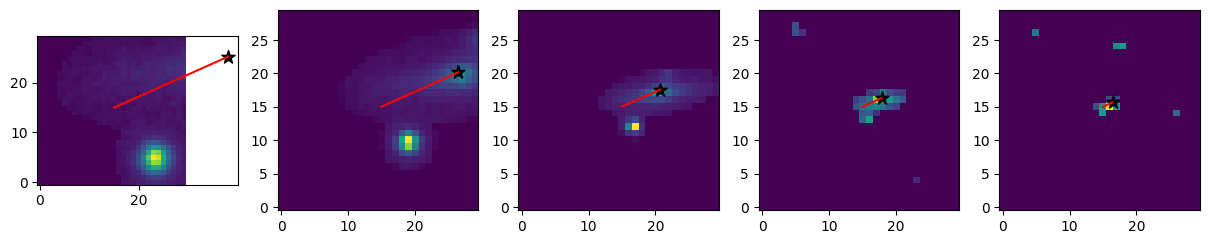

In [640]:
plot_example(X_train, y_train, idx=25)

### Album

In [ ]:
import albumentations as A

In [482]:
def plot(X,y,idx):

    transform = A.Compose([
    A.RandomRotate90(p=1.0),
    A.HorizontalFlip(),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
    
    keypoint = (y[idx][1] + 15, y[idx][0] + 15)  # (x, y)
    transformed = transform(image=X[idx], keypoints=[keypoint])
    transformed_image = transformed['image']
    transformed_keypoints = transformed['keypoints']

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Imagen transformada con keypoint
    axs[0].imshow(transformed_image[:, :, 0], origin="lower")
    axs[0].scatter(transformed_keypoints[0][0], transformed_keypoints[0][1], color='black', marker='*', s=100)
    axs[0].set_title('Imagen transformada')

    # Imagen original
    axs[1].imshow(X[idx][:,:,0] ,origin="lower")
    axs[1].scatter(15+y[idx][1], 15+y[idx][0],color='black', marker='*', s=100)

    axs[1].set_title('Imagen original')

    plt.tight_layout()
    plt.show()

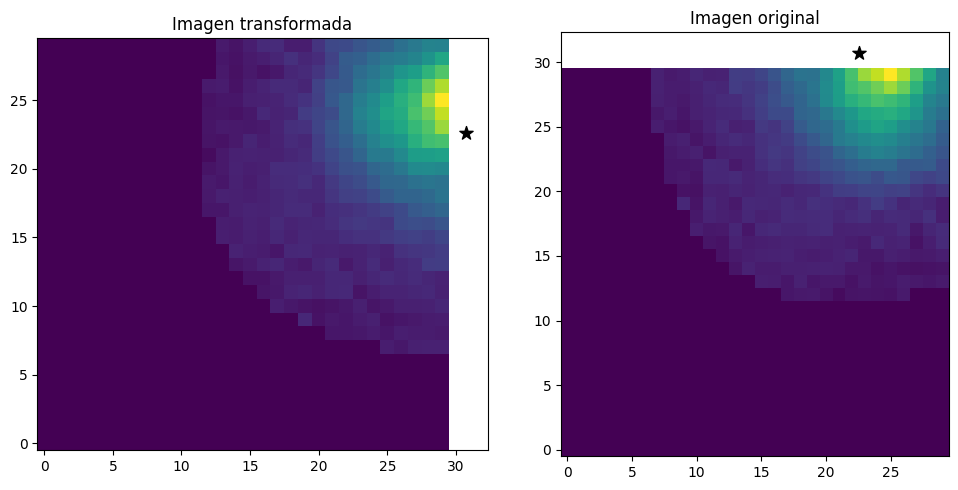

In [486]:
plot(X_train,y_train,idx=301)

In [49]:
import torch
import random

import numpy as np

from typing import Sequence
from torch.utils.data import DataLoader, Dataset


class CustomDataset(Dataset):
    def __init__(self,imgs, sn_pos, transform=None):

        self.imgs = imgs
        self.sn_pos =sn_pos
        self.transform = transform

    def __len__(self):
        return len(self.sn_pos)

    def __getitem__(self, idx):

        image = self.imgs[idx]  
        keypoints = self.sn_pos[idx][::-1] +15
        #keypoints = (self.sn_pos[idx][0]+15, self.sn_pos[idx][1]+15)

        if self.transform:
            transformed = self.transform(image=image, keypoints=[keypoints])
            image = transformed["image"]
            keypoints = transformed["keypoints"]

            return image, np.array(keypoints[0])
        
        else:
            transforms = [
                A.NoOp(),
                A.Rotate(limit=(90, 90), p=1.0),
                A.Rotate(limit=(180, 180), p=1.0),
                A.Rotate(limit=(270, 270), p=1.0),
                A.HorizontalFlip(p=1.0),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(90, 90), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(180, 180), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(270, 270), p=1.0)]),
            ]

            images = []
            keys = []

            for t in transforms:
                composed = A.Compose([t, A.pytorch.ToTensorV2()], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                transformed = composed(image=image, keypoints=[keypoints])
                images.append(transformed["image"])
                keys.append(transformed["keypoints"][0])

            return np.expand_dims(np.stack(images), axis=2), np.stack(keypoints)

In [50]:
dataset = CustomDataset(X_train, y_train, transform=None)

In [51]:
dataset[0][0].shape

(8, 5, 1, 30, 30)

In [52]:
loader = DataLoader(
          dataset,
          batch_size=4,
          shuffle=False,
          pin_memory=False,
        )


In [53]:
batch = next(iter(loader))


In [56]:
batch[0].shape

torch.Size([4, 8, 5, 1, 30, 30])

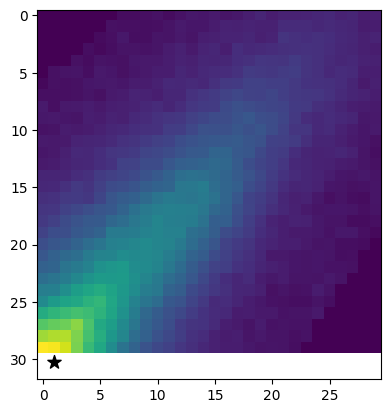

In [ ]:
batch = next(iter(loader))

idx =3
image = batch[0][idx]
keypoints = batch[1][idx]

plt.imshow(image[:,:,0])
plt.scatter(keypoints[0], keypoints[1], color='black', marker='*', s=100)

plt.show()

### Test dataloader

In [85]:
import torch
import random

import numpy as np
import lightning as L

from torch.utils.data import DataLoader, Dataset
import albumentations as A

In [150]:
class DelighDataset(Dataset):
    def __init__(self,imgs, sn_pos, augmentation="delight"):

        self.imgs = imgs
        self.sn_pos =sn_pos
        self.augmentation = augmentation

    def __len__(self):
        return len(self.sn_pos)

    def __getitem__(self, idx):

        image = self.imgs[idx]  
        keypoints = self.sn_pos[idx][::-1] + 15

        if self.augmentation == "data_augmentation":

            transform = A.Compose([
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.pytorch.ToTensorV2()
                ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                
            transformed = transform(image=image, keypoints=[keypoints])
            image = transformed["image"]
            keypoints = transformed["keypoints"]

            return image, np.array(keypoints[0])
        
        elif self.augmentation == "delight":
            transforms = [
                A.NoOp(),
                A.Rotate(limit=(90, 90), p=1.0),
                A.Rotate(limit=(180, 180), p=1.0),
                A.Rotate(limit=(270, 270), p=1.0),
                A.HorizontalFlip(p=1.0),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(90, 90), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(180, 180), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(270, 270), p=1.0)]),
            ]

            images = []
            keys = []

            for t in transforms:
                composed = A.Compose([t, A.pytorch.ToTensorV2()], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                transformed = composed(image=image, keypoints=[keypoints])
                images.append(transformed["image"])
                keys.append(transformed["keypoints"][0])

            return np.expand_dims(np.stack(images), axis=2), np.stack(keys)
        

        elif self.augmentation == "None":

            transform = A.Compose([
                A.pytorch.ToTensorV2()
                ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                
            transformed = transform(image=image, keypoints=[keypoints])
            image = transformed["image"]
            keypoints = transformed["keypoints"]

            return image, np.array(keypoints[0])
            

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class DelightDataModule(L.LightningDataModule):
    
    def __init__(self, X_train, X_val, X_test,
                 y_train, y_val, y_test, batch_size=128, seed=0, num_workers =4, train_augmentation="delight"):
        super().__init__()
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test

        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test


        self.batch_size = batch_size
        self.seed = seed
        self.num_workers = num_workers
        self.train_augmentation = train_augmentation

        self.persistent = num_workers > 0 and torch.cuda.is_available()


    def setup(self, stage=None):
        
        self.train_dataset = DelighDataset(
          self.X_train,
          self.y_train,
          augmentation=self.train_augmentation,
        )

        self.val_dataset = DelighDataset(
          self.X_val,
          self.y_val,
          augmentation = self.train_augmentation if self.train_augmentation == "delight" else "None"
        )


        self.test_dataset = DelighDataset(
          self.X_test,
          self.y_test,
          augmentation= self.train_augmentation if self.train_augmentation == "delight" else "None",
          )
        

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

In [151]:
X_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_train.npy")
X_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_validation.npy")
X_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_test.npy")

y_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_train.npy")
y_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_validation.npy")
y_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_test.npy")

In [169]:
L.seed_everything(0, workers=True)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision("medium")

dm = DelightDataModule(X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, batch_size=4, num_workers=0, seed=0)

dm.setup()

Seed set to 0


In [170]:
from dataclasses import dataclass


@dataclass
class DelightCnnParameters:
    """Defines DelightCnn parameters.

    Attributes:
    - nconv1: Number of out channels for first convolutional layer.
    - nconv2: Number of out channels for second convolutional layer.
    - nconv3: Number of out channels for third convolutional layer.
    - ndense: Number of out features for first fully-connected layer.
    - dropout: Probability of dropout. 0 means no dropout.
    - channels: Number of channels expected from the dataset.
    - levels: Quantity of levels expected from the dataset.
    - rot: Applies a rotation transformation on the input.
    - flip: Applies a flip transformation on the input.
    """

    nconv1: int
    nconv2: int
    nconv3: int
    ndense: int
    dropout: float
    channels: int
    levels: int

In [171]:
import math
from collections import OrderedDict

import torch

class DelightCnn(torch.nn.Module):
    def __init__(self, options: DelightCnnParameters):
        super().__init__()  # type: ignore
        bottleneck: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                ("conv1", torch.nn.Conv2d(options.channels, options.nconv1, 3)),
                ("relu1", torch.nn.ReLU()),
                ("mp1", torch.nn.MaxPool2d(2)),
                ("conv2", torch.nn.Conv2d(options.nconv1, options.nconv2, 3)),
                ("relu2", torch.nn.ReLU()),
                ("mp2", torch.nn.MaxPool2d(2)),
                ("conv3", torch.nn.Conv2d(options.nconv2, options.nconv3, 3)),
                ("relu3", torch.nn.ReLU()),
                ("flatten", torch.nn.Flatten()),
            ]
        )
        regression: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                (
                    "input_layer_ffcc",
                    torch.nn.Linear(
                        in_features=4*4*options.nconv3*options.levels,
                        out_features=options.ndense,
                    ),
                ),
                ("tanh", torch.nn.Tanh()),
                ("dropout", torch.nn.Dropout(p=options.dropout)),
                ("out", torch.nn.Linear(in_features=options.ndense, out_features=2)),
            ]
        )

        self.bottleneck = torch.nn.Sequential(bottleneck)
        self.regression = torch.nn.Sequential(regression)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch = x.shape[0]  

        print(x.shape)

        x = x.reshape(x.shape[-6] * x.shape[-5] * x.shape[-4] , x.shape[-3], x.shape[-2], x.shape[-1])

        print(x.shape)
        x = self.bottleneck(x)

        print(x.shape)
        x = x.reshape(batch, 8, -1)
        print(x.shape)

        x = self.regression(x)
        print(x.shape)

        return x

In [172]:
model_parameters = DelightCnnParameters(
    nconv1=52,
    nconv2=57,
    nconv3=41,
    ndense=128,
    dropout=0.06,
    channels=1,
    levels=5,
)

model = DelightCnn(model_parameters)

In [173]:
batch = next(iter(dm.train_dataloader()))
imgs = batch[0]
targets = batch[1]

In [174]:
targets.dtype

torch.float64

In [175]:
targets.shape

torch.Size([4, 8, 2])

In [158]:
targets.shape

torch.Size([4, 8, 2])

In [159]:
out = model(imgs.float())

torch.Size([4, 8, 5, 1, 30, 30])
torch.Size([160, 1, 30, 30])
torch.Size([160, 656])
torch.Size([4, 8, 3280])
torch.Size([4, 8, 2])


In [160]:
out.shape

torch.Size([4, 8, 2])

In [164]:
import torch
import torch.nn.functional as F

# Supongamos que ya tienes output y target
output = torch.randn(4, 8, 2)
target = torch.randn(4, 8, 2)

loss = F.mse_loss(output, target)
print(loss)

tensor(2.2832)


In [165]:
mse = torch.nn.MSELoss()

In [166]:
mse(out, targets)

tensor(259.4515, dtype=torch.float64, grad_fn=<MseLossBackward0>)

## ALL

In [ ]:
import torch
import random

import numpy as np
import lightning as L

from torch.utils.data import DataLoader, Dataset
import albumentations as A


L.seed_everything(0, workers=True)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_float32_matmul_precision("medium")



class DelighDataset(Dataset):
    def __init__(self,imgs, sn_pos, augmentation="delight"):

        self.imgs = imgs
        self.sn_pos =sn_pos
        self.augmentation = augmentation

    def __len__(self):
        return len(self.sn_pos)

    def __getitem__(self, idx):

        image = self.imgs[idx]  
        keypoints = self.sn_pos[idx][::-1] + 15

        if self.augmentation == "data_augmentation":

            transform = A.Compose([
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.pytorch.ToTensorV2()
                ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                
            transformed = transform(image=image, keypoints=[keypoints])
            image = transformed["image"]
            keypoints = transformed["keypoints"]

            return torch.stack(images).unsqueeze(2).float(), torch.tensor(keys).float()
        
        elif self.augmentation == "delight":

            transforms = [
                A.NoOp(),
                A.Rotate(limit=(90, 90), p=1.0),
                A.Rotate(limit=(180, 180), p=1.0),
                A.Rotate(limit=(270, 270), p=1.0),
                A.HorizontalFlip(p=1.0),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(90, 90), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(180, 180), p=1.0)]),
                A.Compose([A.HorizontalFlip(p=1.0), A.Rotate(limit=(270, 270), p=1.0)]),
            ]

            images = []
            keys = []

            for t in transforms:
                composed = A.Compose([t, A.pytorch.ToTensorV2()], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                transformed = composed(image=image, keypoints=[keypoints])
                images.append(transformed["image"])
                keys.append(transformed["keypoints"][0])

            return torch.stack(images).unsqueeze(2).float(), torch.tensor(keys).float()
        

        elif self.augmentation == "None":
            
            transform = A.Compose([
                A.pytorch.ToTensorV2()
                ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))
                
            transformed = transform(image=image, keypoints=[keypoints])
            image = transformed["image"]
            keypoints = transformed["keypoints"]

            return image.unsqueeze(1).float(), torch.tensor(keypoints[0]).float()
            

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class DelightDataModule(L.LightningDataModule):
    
    def __init__(self, X_train, X_val, X_test,
                 y_train, y_val, y_test, batch_size=128, seed=0, num_workers =4, train_augmentation="delight"):
        super().__init__()
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test

        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test


        self.batch_size = batch_size
        self.seed = seed
        self.num_workers = num_workers
        self.train_augmentation = train_augmentation

        self.persistent = num_workers > 0 and torch.cuda.is_available()


    def setup(self, stage=None):
        
        self.train_dataset = DelighDataset(
          self.X_train,
          self.y_train,
          augmentation=self.train_augmentation,
        )

        self.val_dataset = DelighDataset(
          self.X_val,
          self.y_val,
          augmentation = self.train_augmentation if self.train_augmentation == "delight" else "None"
        )


        self.test_dataset = DelighDataset(
          self.X_test,
          self.y_test,
          augmentation= self.train_augmentation if self.train_augmentation == "delight" else "None",
          )
        

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

    def predict_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            persistent_workers=self.persistent,
            pin_memory=False,
            worker_init_fn=seed_worker,
            generator=torch.Generator().manual_seed(self.seed)
        )

X_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_train.npy")
X_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_validation.npy")
X_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/X_test.npy")

y_train = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_train.npy")
y_val = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_validation.npy")
y_test = np.load("/Users/legers/Desktop/Galaxias/tesis/data/y_test.npy")

from dataclasses import dataclass


@dataclass
class DelightCnnParameters:
    """Defines DelightCnn parameters.

    Attributes:
    - nconv1: Number of out channels for first convolutional layer.
    - nconv2: Number of out channels for second convolutional layer.
    - nconv3: Number of out channels for third convolutional layer.
    - ndense: Number of out features for first fully-connected layer.
    - dropout: Probability of dropout. 0 means no dropout.
    - channels: Number of channels expected from the dataset.
    - levels: Quantity of levels expected from the dataset.
    - rot: Applies a rotation transformation on the input.
    - flip: Applies a flip transformation on the input.
    """

    nconv1: int
    nconv2: int
    nconv3: int
    ndense: int
    dropout: float
    channels: int
    levels: int


from collections import OrderedDict

import torch

class DelightCnn(torch.nn.Module):
    def __init__(self, options: DelightCnnParameters):
        super().__init__()  # type: ignore
        bottleneck: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                ("conv1", torch.nn.Conv2d(options.channels, options.nconv1, 3)),
                ("relu1", torch.nn.ReLU()),
                ("mp1", torch.nn.MaxPool2d(2)),
                ("conv2", torch.nn.Conv2d(options.nconv1, options.nconv2, 3)),
                ("relu2", torch.nn.ReLU()),
                ("mp2", torch.nn.MaxPool2d(2)),
                ("conv3", torch.nn.Conv2d(options.nconv2, options.nconv3, 3)),
                ("relu3", torch.nn.ReLU()),
                ("flatten", torch.nn.Flatten()),
            ]
        )
        regression: OrderedDict[str, torch.nn.Module] = OrderedDict(
            [
                (
                "input_layer_fc",
                    torch.nn.Linear(
                        in_features=4*4*options.nconv3*options.levels,
                        out_features=options.ndense,
                    ),
                ),
                ("tanh", torch.nn.Tanh()),
                ("dropout", torch.nn.Dropout(p=options.dropout)),
                ("out", torch.nn.Linear(in_features=options.ndense, out_features=2)),
            ]
        )

        self.bottleneck = torch.nn.Sequential(bottleneck)
        self.regression = torch.nn.Sequential(regression)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        original_shape  = x.shape

        leading = torch.prod(torch.tensor(original_shape[:-3])).item() # Batch*Transforms*Levels

        x = x.reshape(leading, original_shape[-3], original_shape[-2], original_shape[-1])

        x = self.bottleneck(x)

        new_shape = original_shape[:-4] + (-1,)

        x = x.reshape(*new_shape)

        x = self.regression(x)

        return x


model_parameters = DelightCnnParameters(
    nconv1=52,
    nconv2=57,
    nconv3=41,
    ndense=128,
    dropout=0.06,
    channels=1,
    levels=5,
)

model = DelightCnn(model_parameters)


dm = DelightDataModule(X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, batch_size=4, num_workers=0, seed=0, train_augmentation="None")

dm.setup()

batch = next(iter(dm.train_dataloader()))
imgs = batch[0]
targets = batch[1]

print(imgs.dtype, targets.dtype)
    

Seed set to 0


torch.float32 torch.float32


/Users/legers/Desktop/Galaxias/env_galaxias/lib/python3.11/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


In [295]:
out = model(imgs)
out.shape

torch.Size([4, 2])

In [220]:
mse = torch.nn.MSELoss()

mse(out, targets)

tensor(259.3111, grad_fn=<MseLossBackward0>)

In [298]:
bottleneck = torch.nn.Sequential(
            [
                ("conv1", torch.nn.Conv2d(1, 2, 3)),
                ("relu1", torch.nn.ReLU()),
                ("mp1", torch.nn.MaxPool2d(2)),
                ("conv2", torch.nn.Conv2d(2, 4, 3)),
                ("relu2", torch.nn.ReLU()),
                ("mp2", torch.nn.MaxPool2d(2)),
                ("conv3", torch.nn.Conv2d(4, 16, 3)),
                ("relu3", torch.nn.ReLU()),
                ("flatten", torch.nn.Flatten()),
            ]
        )

TypeError: list is not a Module subclass